# 3D Evaluation for HDBSCAN

In [1]:
# Reload the notebook if an external file is updated
%load_ext autoreload
%autoreload 2

import os
import sys

from pathlib import Path

path = (
    Path
    .cwd()
    .parent
    .parent
    .joinpath('warbler')
    .as_posix()
)

os.chdir(path)
sys.path.append(path)

In [2]:
import clusteval
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns

from datatype.dataset import Dataset
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from datatype.spectrogram import flatten
from umap import UMAP, validation

In [ ]:
plt.style.use('science')

In [3]:
dataset = Dataset('segment')
dataframe = dataset.load()

In [4]:
spectrogram = dataframe['scale'].tolist()
flattened = flatten(spectrogram)

In [5]:
um = UMAP(
    low_memory=True,
    metric='euclidean',
    min_dist=0.0,
    n_neighbors=5,
    n_components=3,
    n_jobs=-1
)

In [6]:
embedding = um.fit_transform(flattened)

In [8]:
coordinates = (
    dataframe.umap_x_3d, 
    dataframe.umap_y_3d, 
    dataframe.umap_z_3d
)

embedding = np.column_stack(coordinates)

[clusteval] >Evaluate using dbindex.


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.45it/s]


[clusteval] >Evaluate using silhouette.


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [02:15<00:00,  5.88s/it]


[clusteval] >Evaluate using derivatives.
[clusteval] >Determining optimal clustering by derivatives..
[clusteval] >Clusters: 4


<Figure size 640x480 with 0 Axes>

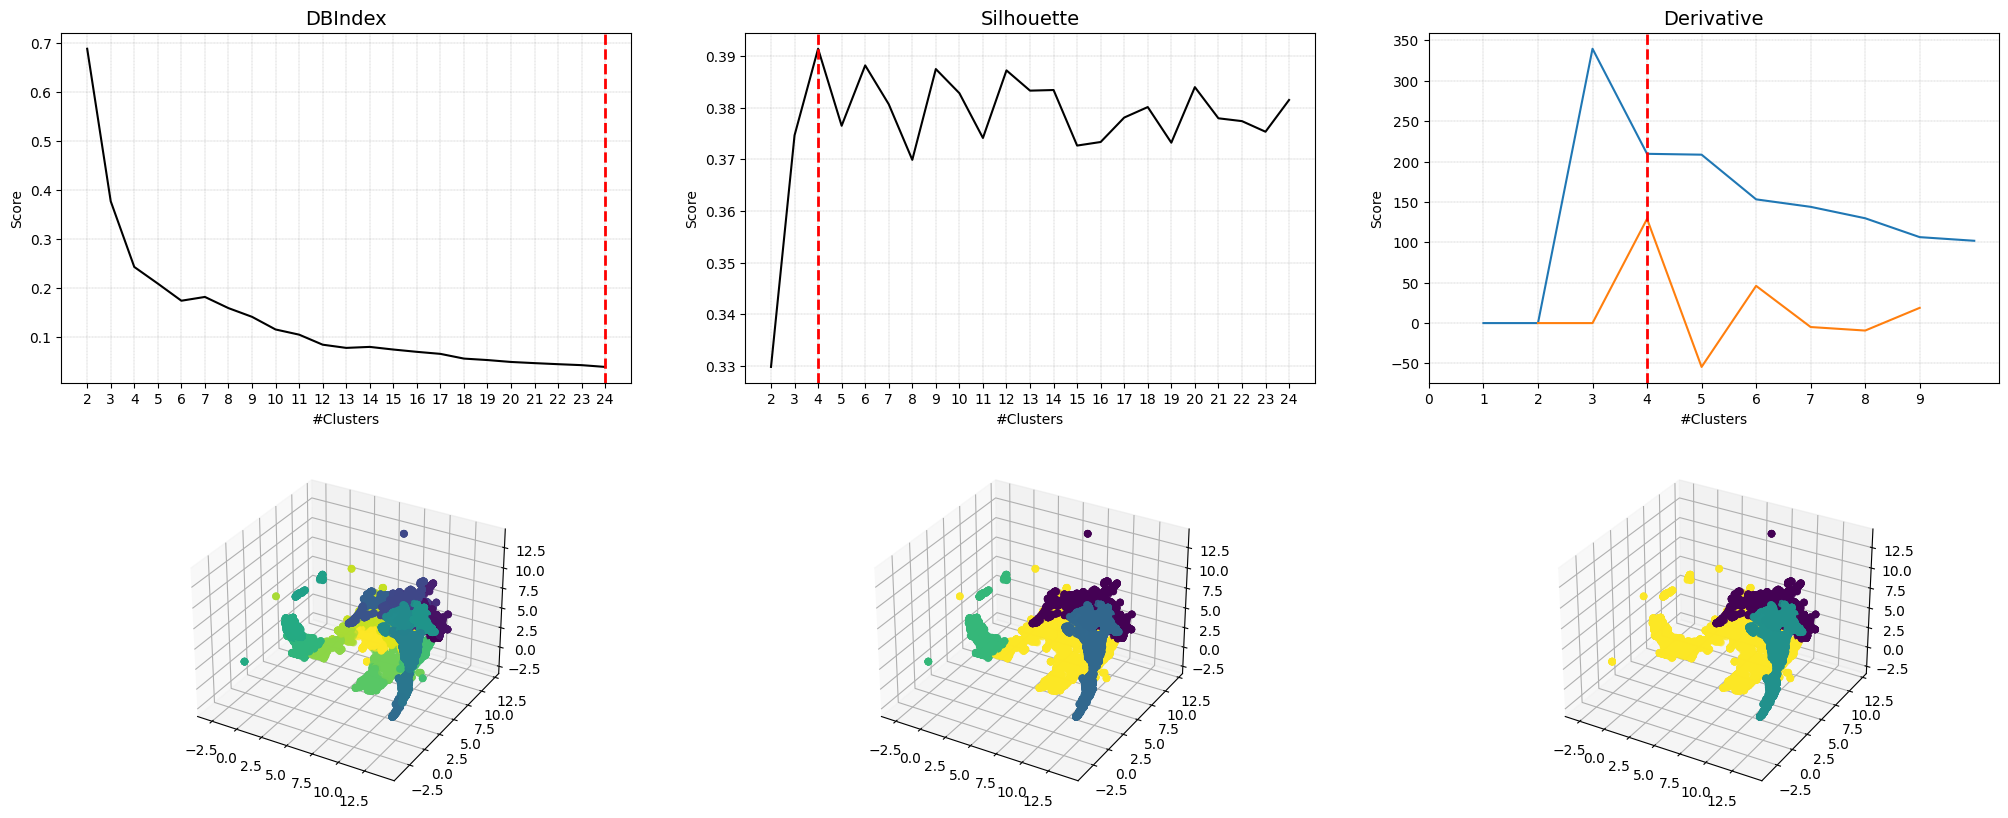

In [14]:
plt.figure()

fig, axs = plt.subplots(
    2,
    3, 
    figsize=(25, 10)
)

# DBIndex
results = clusteval.dbindex.fit(embedding)

_ = clusteval.dbindex.plot(
    results, 
    title='DBIndex', 
    ax=axs[0][0], 
    visible=False
)

axs[1, 0].remove()
axs[1, 0] = fig.add_subplot(2, 3, 4, projection='3d')

axs[1][0].scatter(
    embedding[:, 0], 
    embedding[:, 1],
    embedding[:, 2],
    c=results['labx']
)

axs[1][0].grid(True)

# Silhouette
results = clusteval.silhouette.fit(embedding)

_ = clusteval.silhouette.plot(
    results, 
    title='Silhouette', 
    ax=axs[0][1], 
    visible=False
)

axs[1, 1].remove()
axs[1, 1] = fig.add_subplot(2, 3, 5, projection='3d')

axs[1][1].scatter(
    embedding[:, 0], 
    embedding[:, 1],
    embedding[:, 2],
    c=results['labx']
)

axs[1][1].grid(True)

# Derivative
results = clusteval.derivative.fit(embedding)

_ = clusteval.derivative.plot(
    results, 
    title='Derivative', 
    ax=axs[0][2], 
    visible=False
)

axs[1, 2].remove()
axs[1, 2] = fig.add_subplot(2, 3, 6, projection='3d')

axs[1][2].scatter(
    embedding[:, 0], 
    embedding[:, 1],
    embedding[:, 2],
    c=results['labx']
)

plt.show()
plt.close()

In [ ]:
# Intialize model
ce = clusteval.clusteval(cluster='hdbscan')

# Cluster evaluation
results = ce.fit(embedding)

# Make plots
ce.plot()
ce.scatter(embedding)

In [18]:
cluster = hdbscan.HDBSCAN(
    cluster_selection_method='eom',
    min_cluster_size=100,
    min_samples=10,
    gen_min_span_tree=True
).fit(embedding)

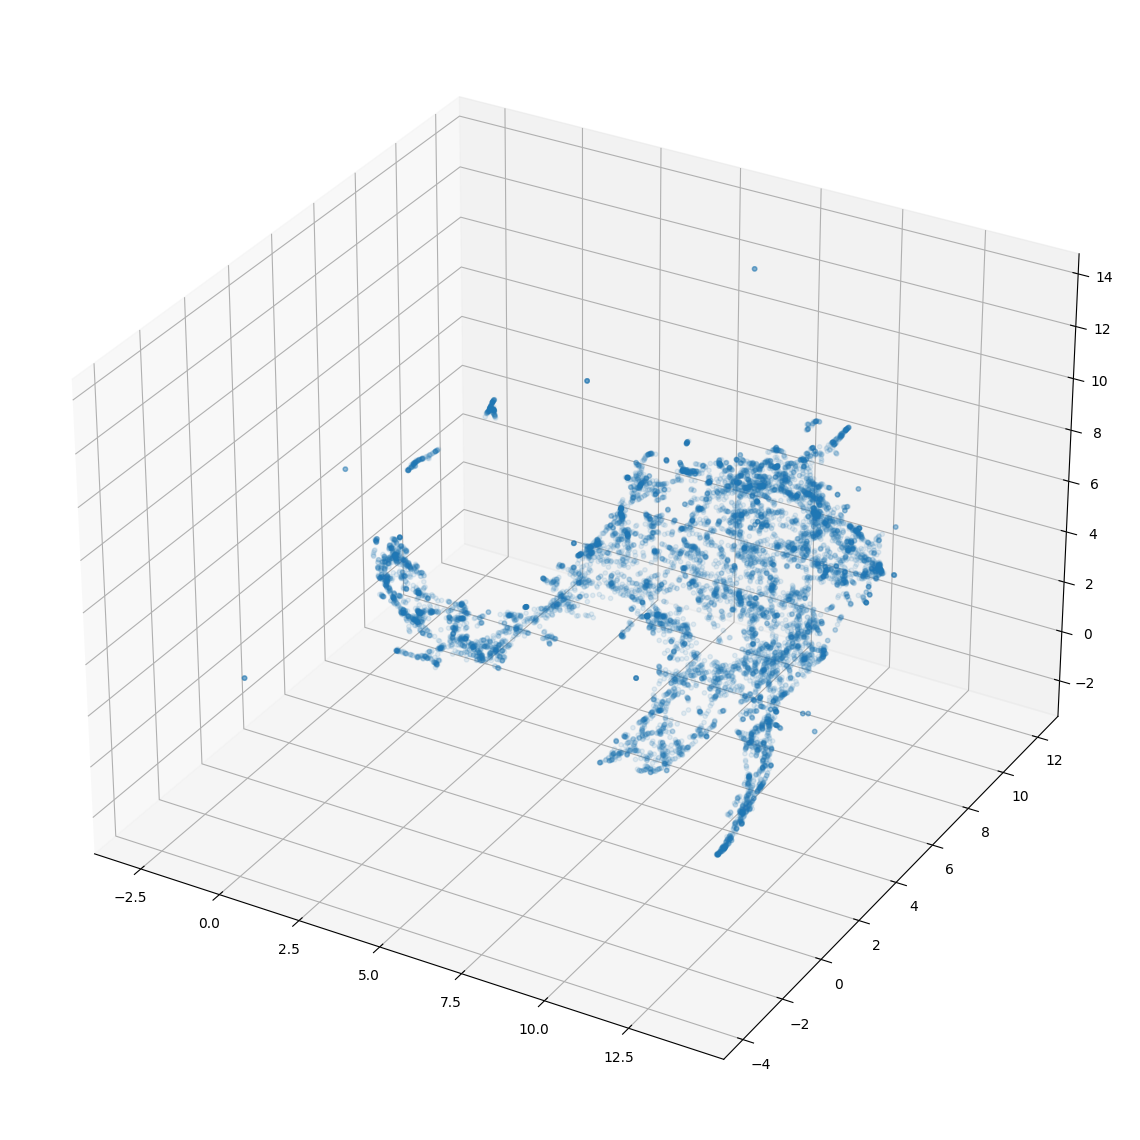

In [19]:
figsize = (32, 32)

fig = plt.figure(figsize=figsize)

ax = fig.add_subplot(
    2, 
    1, 
    2, 
    projection='3d'
)

ax.scatter(
    embedding[:, 0], 
    embedding[:, 1],
    embedding[:, 2],
    s=10,
    alpha=0.10
)

plt.show()
plt.close()

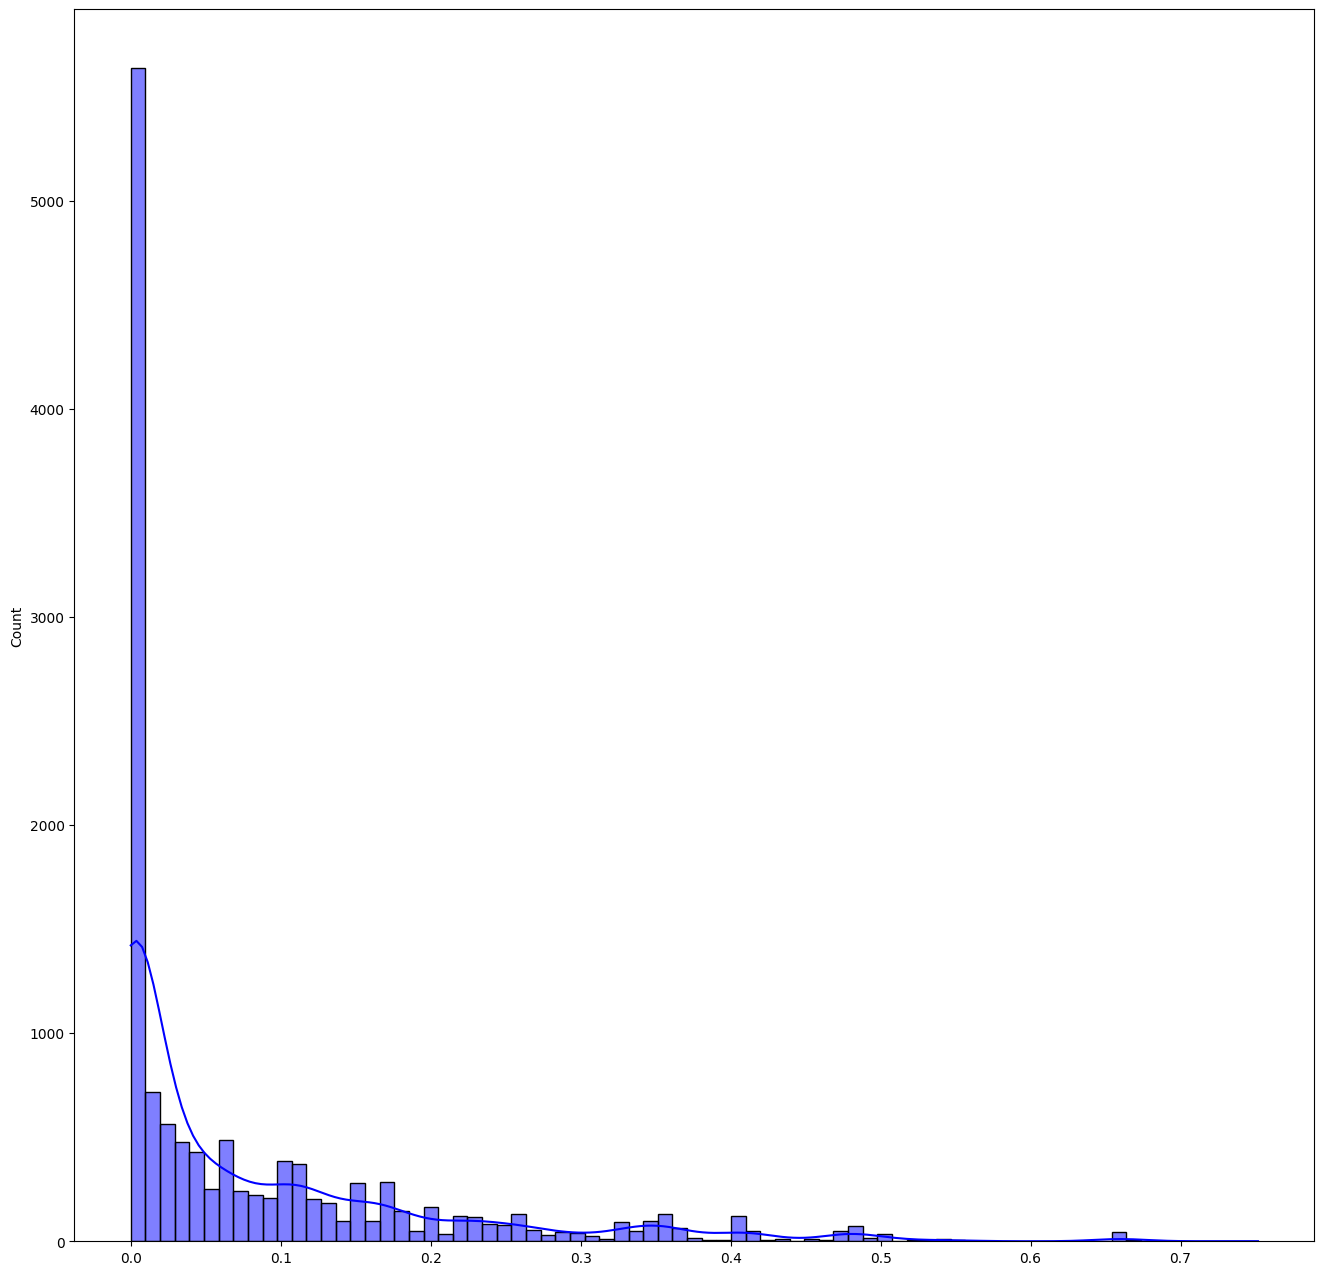

In [21]:
figsize = (16, 16)
fig, ax = plt.subplots(figsize=figsize)

sns.histplot(
    cluster.outlier_scores_[np.isfinite(cluster.outlier_scores_)],
    ax=ax,
    color='blue',
    kde=True
)

# ax.set_xlim(0, 0.6)
# ax.set_ylim(0, 2000)

plt.show()
plt.close()

e:\code\personal\warbler.py\venv\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


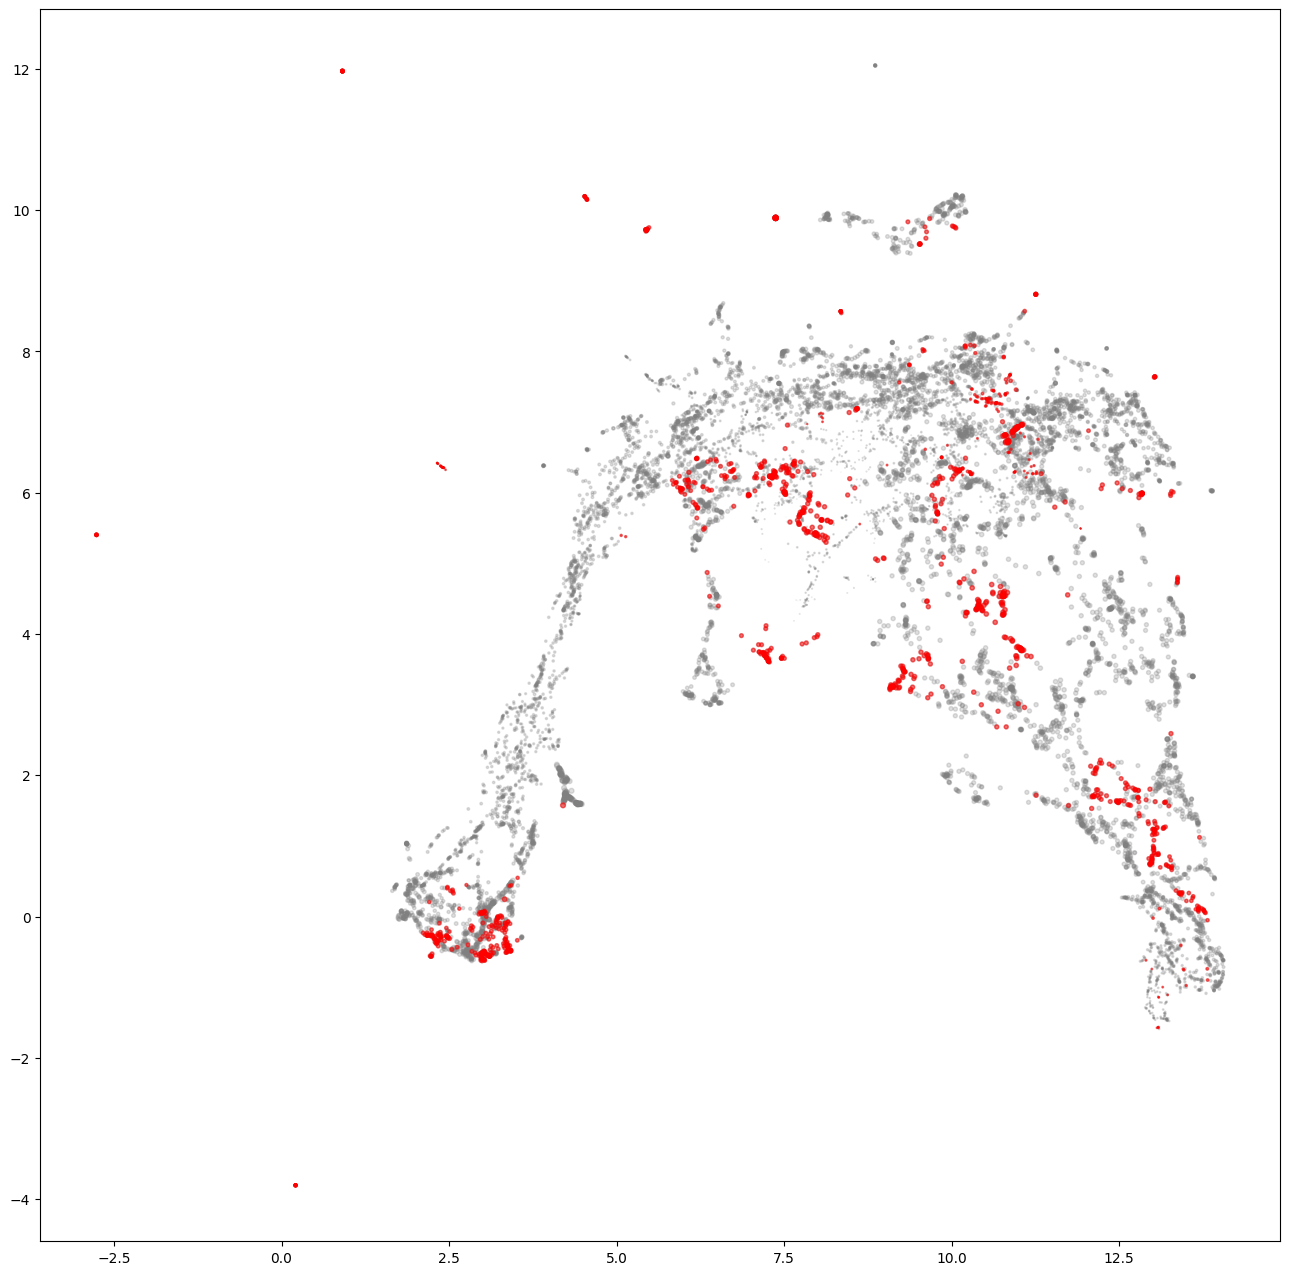

In [22]:
threshold = pd.Series(cluster.outlier_scores_).quantile(0.9)
outliers = np.where(cluster.outlier_scores_ > threshold)[0]

figsize = (16, 16)
fig, ax = plt.subplots(figsize=figsize)

plt.scatter(
    *embedding.T,
    alpha=0.25,
    c='gray'
)

plt.scatter(
    *embedding[outliers].T,
    alpha=0.5,
    c='red'
)

plt.show()
plt.close()